# Assignment 5: Classification

## Step 1. Assumptions

* Divide the data by z-layer into 11 slices.  
* Assume the mean density of synapses in a slice can be classified into 2 groups: $W_i$.  
* $W_i = \{\text{High density},\text{  Low density}\}$  




## Step 2. Define classification problem

* We then randomly choose a small grid, and use the $X$ and $Y$ position to predict this grid belongs to high or low density.  
  
* $N$ is the number of synapses (observations)
* $X_i = X\text{ position} $  
* $Y_i = Y\text{ position} $  
* $H_0 = N \perp\!\!\!\perp X, Y$ positions
* $H_1 = N \text{ is not} \perp\!\!\!\perp X, Y$ positions  


* Becuase we will do the classification, the objective is to minimize the expected error:  
* $E[l] = \sum_{n=1}^{\infty}I(\hat{W_i} \neq W_i)$ where $I$ is the indicator function.


## Step 3. Provide algorithms

Classification methods:

* lda (Linear Discriminant Analysis): No parameter.
* qda (Quadratic Discriminant Analysis): No parameter.
* svm (Support Vector Machine): Linear kernel, penalty parameter set to 0.001, to improve computation time.
* knn (K-Nearest Neighbours): Number of neighbors set to 3.
* rf (Random Forest): Default values except maximum depth set to 5.

## Step 4. Sample data from null and alternative model

In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

np.random.seed(12345678)  # for reproducibility, set random seed


## Step 5. Compute accuracy

## Step 6. Apply on data

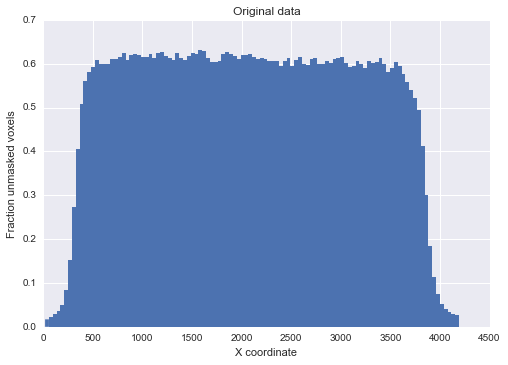

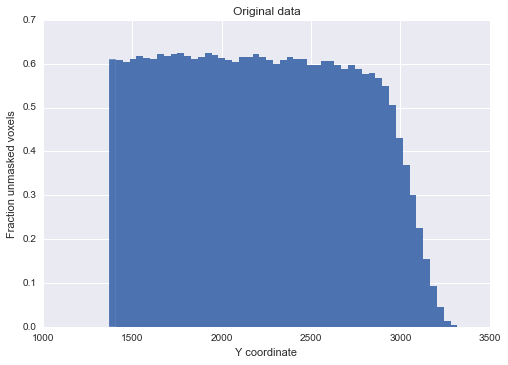

In [2]:
# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# print xvals
# print yvals
# print zvals

plt.hist(df['cx'], weights=df['unmasked']/(nvox*len(yvals)*len(zvals)), 
         bins=len(xvals), edgecolor='none')
plt.xlabel('X coordinate')
plt.ylabel('Fraction unmasked voxels')
plt.title('Original data')
plt.show()

plt.hist(df['cy'], weights=df['unmasked']/(nvox*len(xvals)*len(zvals)), 
         bins=len(yvals), edgecolor='none')
plt.xlabel('Y coordinate')
plt.ylabel('Fraction unmasked voxels')
plt.title('Original data')
plt.show()

In [3]:
# Get rid of the blank edges, Z-layer by Z-layer.
df['edge'] = 0

for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = np.argmax(xhist>0.5)
    right = len(xvals)-np.argmax(xhist[::-1]>0.5)
    
    df.loc[(df['cz']==z) & ((df['cx']<xvals[left]) | (df['cx']>=xvals[right])),'edge'] = 1
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = np.argmax(yhist>0.5)
    bottom = len(yvals)-np.argmax(yhist[::-1]>0.5)
    
    df.loc[(df['cz']==z) & ((df['cy']<yvals[top]) | (df['cy']>=yvals[bottom])),'edge'] = 1
    
print 'We labeled',np.sum(df['edge']==1),'bins as edges.'

We labeled 20203 bins as edges.


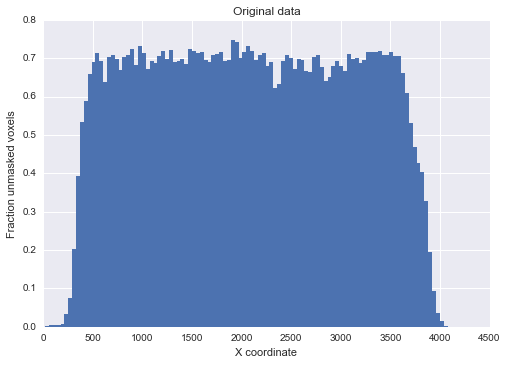

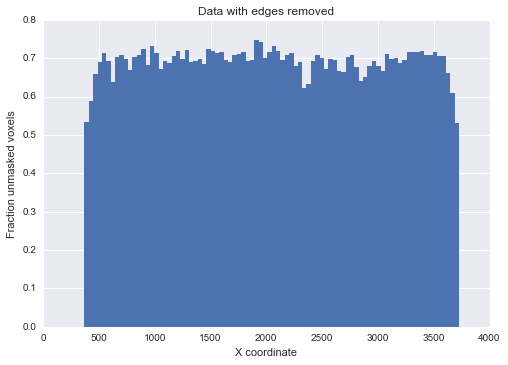

In [4]:
# Example: removing edges along X dimension for one Z-plane
plt.figure()
plt.bar(xvals, xhist, width=40, edgecolor='none')
plt.title('Original data')
plt.xlabel('X coordinate')
plt.ylabel('Fraction unmasked voxels')
plt.show()

plt.figure()
plt.bar(xvals[left:right], xhist[left:right], width=40, edgecolor='none')
plt.title('Data with edges removed')
plt.xlabel('X coordinate')
plt.ylabel('Fraction unmasked voxels')
plt.show()

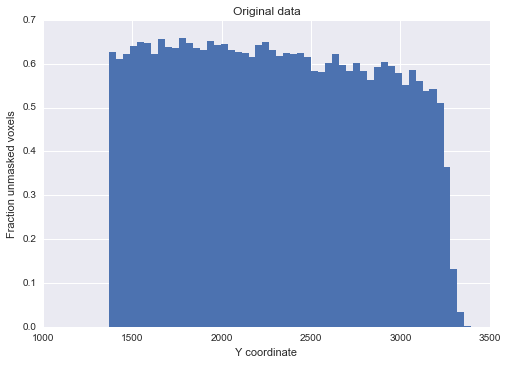

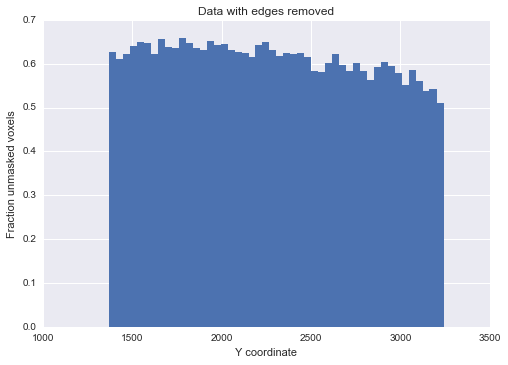

In [5]:
# Example: removing edges along Y dimension for one Z-plane
plt.figure()
plt.bar(yvals, yhist, width=40, edgecolor='none')
plt.title('Original data')
plt.xlabel('Y coordinate')
plt.ylabel('Fraction unmasked voxels')
plt.show()

plt.figure()
plt.bar(yvals[top:bottom], yhist[top:bottom], width=40, edgecolor='none')
plt.title('Data with edges removed')
plt.xlabel('Y coordinate')
plt.ylabel('Fraction unmasked voxels')
plt.show()

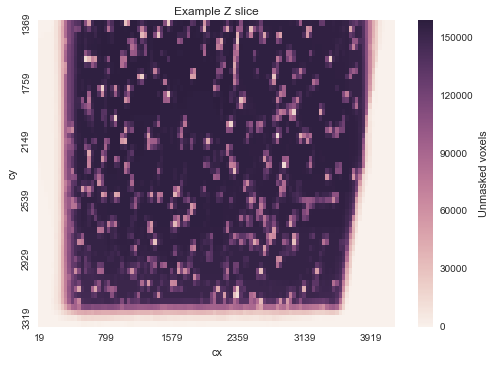

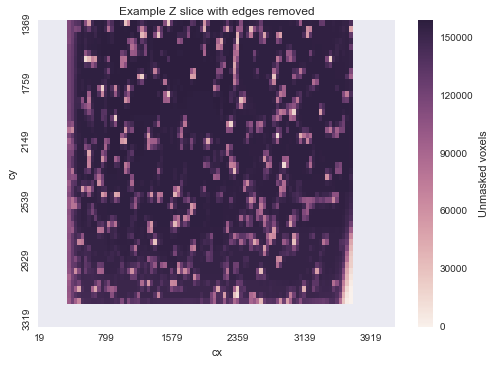

In [6]:
# Example Z slice before and after removing edges
Zslice = df[df['cz']==z].pivot_table(index='cy', columns='cx', values=['unmasked','edge'], aggfunc=np.sum)
plt.figure()
sns.heatmap(Zslice['unmasked'], xticklabels=20, yticklabels=10, 
            cbar_kws={'label': 'Unmasked voxels'});
plt.title('Example Z slice');

plt.figure()
sns.heatmap(Zslice[Zslice['edge']==0]['unmasked'], xticklabels=20, yticklabels=10, 
            cbar_kws={'label': 'Unmasked voxels'});
plt.title('Example Z slice with edges removed');

In [7]:
# Copy new dataset without edges
df2 = df[df['edge']==0].copy()
df2 = df2.drop('edge', axis=1)
print df2.head()

       cx    cy   cz  unmasked  synapses    weighted
4578  331  1369  277    106215       118  218.422483
4589  331  1408  277    107686       120  219.090318
4600  331  1447  277    109206       169  304.257568
4611  331  1486  277    111126       174  307.846877
4622  331  1525  277    112788       140  244.042983


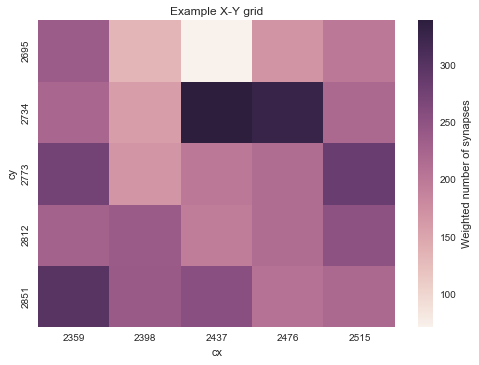

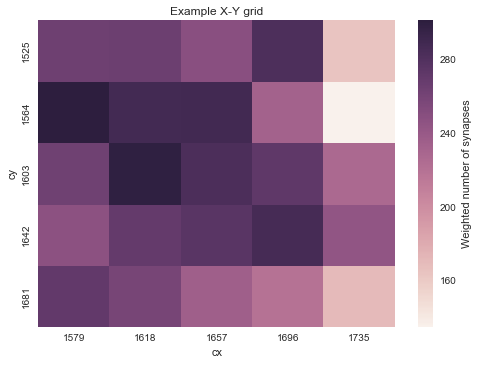

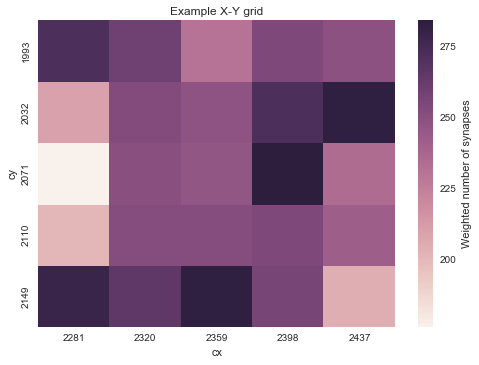

In [8]:
# Generating dataset of 5x5 grids
grids = []
for z in zvals:
    
    # new xvals and yvals vary by Z layer
    nxvals = df2[df2['cz']==z]['cx'].unique()
    nyvals = df2[df2['cz']==z]['cy'].unique()
    
    for i in range(100):
        xi = np.random.randint(2,len(nxvals)-2)
        yi = np.random.randint(2,len(nyvals)-2)
        newgrid = df[
            (df['cx']>=nxvals[xi-2]) & (df['cx']<=nxvals[xi+2]) & 
            (df['cy']>=nyvals[yi-2]) & (df['cy']<=nyvals[yi+2]) &
            (df['cz'] == z)
            ]
        
        grids.append(newgrid)
        
        # plot examples for one Z layer
        if z==55 and i<3:
            exampleXY = pd.pivot_table(grids[i], index='cy', columns='cx', values='weighted', aggfunc=np.sum)
            plt.figure()
            sns.heatmap(exampleXY, cbar_kws={'label': 'Weighted number of synapses'});
            plt.title('Example X-Y grid');

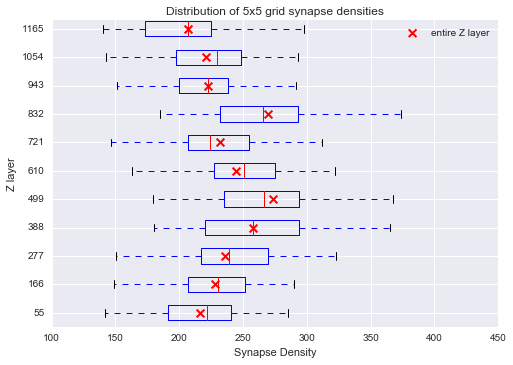

In [9]:
# Mean density by Z layer
grid_means = np.array([g['weighted'].mean() for g in grids])
grid_z = np.array([g['cz'].mean() for g in grids])

z_means = np.array([df2[df2['cz']==z]['weighted'].mean() for z in zvals])

plt.figure()
plt.boxplot([grid_means[grid_z==z] for z in zvals], vert=False, positions=zvals, widths=60)
Z_pts = plt.scatter(z_means, zvals, label='entire Z layer', s=60, color='r', marker='x', linewidths=2)
plt.ylim(0,1200)
plt.xlabel('Synapse Density')
plt.ylabel('Z layer')
plt.title('Distribution of 5x5 grid synapse densities')
plt.legend()
plt.show()

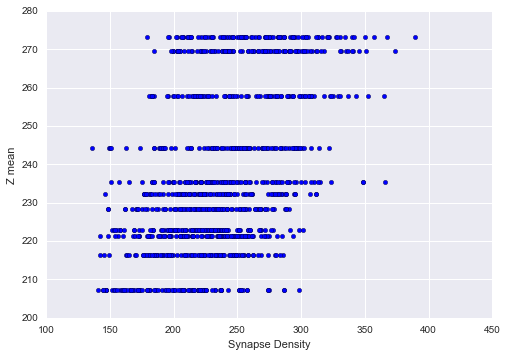

In [10]:
# Mean density by Z mean
grid_z_mean = np.array([df2[df2['cz']==g['cz'].mean()]['weighted'].mean() for g in grids])

plt.figure()
grid_pts = plt.scatter(grid_means, grid_z_mean, label='5x5 grid')
plt.xlabel('Synapse Density')
plt.ylabel('Z mean')
plt.show()

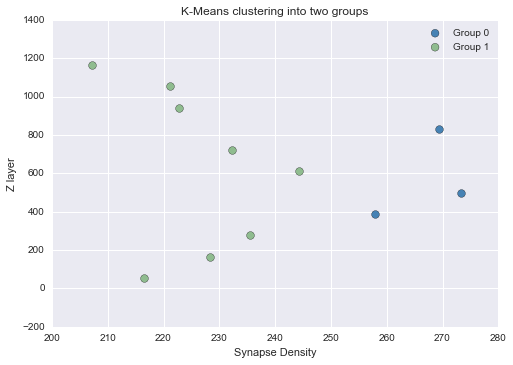

In [11]:
# Split into high density vs. low density layers
from sklearn.cluster import KMeans

est = KMeans(n_clusters=2)
est.fit(z_means.reshape(len(z_means),1))
labels = est.labels_

plt.figure()
pts0 = plt.scatter(z_means[labels==0], zvals[labels==0], s=60, facecolor='steelblue')
pts1 = plt.scatter(z_means[labels==1], zvals[labels==1], s=60, facecolor='darkseagreen')
pts0.set_label('Group 0')
pts1.set_label('Group 1')
plt.xlabel('Synapse Density')
plt.ylabel('Z layer')
plt.title('K-Means clustering into two groups')
plt.legend()
plt.show()

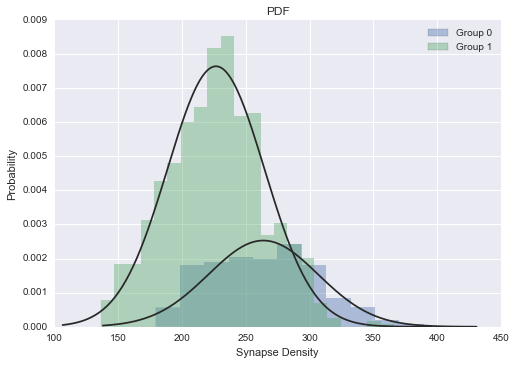

In [12]:
# Plot distributions of our dataset
grid_labels = np.array([ labels[ np.argmax( zvals==g['cz'].mean() ) ] for g in grids ])

g0 = grid_means[np.where(grid_labels==0)]
g1 = grid_means[np.where(grid_labels==1)]

n0 = len(g0)
n1 = len(g1)
p0 = float(n0)/(n0+n1)
p1 = float(n1)/(n0+n1)

plt.figure()
ax = sns.distplot(g0, kde=False, fit=norm, label='Group 0', hist_kws={'edgecolor': 'none'})
sns.distplot(g1, kde=False, fit=norm, label='Group 1', hist_kws={'edgecolor': 'none'})

# weight fit by priors
fit0 = (ax.lines[0].get_data()[0], p0*ax.lines[0].get_data()[1])
ax.lines[0].set_data(fit0)
fit1 = (ax.lines[1].get_data()[0], p1*ax.lines[1].get_data()[1])
ax.lines[1].set_data(fit1)

# weight histograms by priors
scale = -1
for r in ax.patches:
    if r.get_label() == 'Group 0':
        scale = p0
    elif r.get_label() == 'Group 1':
        scale = p1
    if scale != -1:
        h = r.get_height()
        r.set_height(scale*h)

ax.set_ylim(0,0.009)
plt.xlabel('Synapse Density')
plt.ylabel('Probability')
plt.title('PDF')
plt.legend()
plt.show()

In [13]:
# Run classification algorithms on dataset
names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.001), # decreased C to improve computation time
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

features = grid_means.reshape(-1,1)
y = grid_labels

accuracy=np.zeros((len(classifiers),2))
for idx, cla in enumerate(classifiers):
    loo = LeaveOneOut(len(features))
    scores = cross_validation.cross_val_score(cla, features, y, cv=loo)
    accuracy[idx,] = [scores.mean(), scores.std()]
    print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))

Accuracy of Nearest Neighbors: 0.69 (+/- 0.93)
Accuracy of Linear SVM: 0.73 (+/- 0.89)
Accuracy of Random Forest: 0.74 (+/- 0.87)
Accuracy of Linear Discriminant Analysis: 0.76 (+/- 0.85)
Accuracy of Quadratic Discriminant Analysis: 0.76 (+/- 0.85)


## Step 7. Interpret
The five classifiers tested had accuracies between 69-76%, which is better than chance. However, these numbers are only slightly at or above the maximum prior probability of 73%, and in one case (nearest neighbors), it's slightly below the prior. This means that our classifiers are only slightly better than just choosing the class with the maximum prior 100% of the time, assuming we trust the priors. Taking into account the observed synapse density provides little added information, which is not surprising given the large overlap in observed densities from the two classes. If we wanted to distinguish between similar populations of Z layers but with different priors from another dataset, our accuracy would decrease accordingly.